In [35]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
library(readxl)
library(RColorBrewer)

The first step in the analysis of the data was downloading the excel file from the online database into Jupyter, and establishing a training and testing data set. Luckily the data was already separated into these two categories in the original file, allowing for the training and testing groups to be read separately by specifying their respective sheet number. Once downloaded, the table headers were changed into a more readable format using the legend provided (which highlighted the meaning behind the header abbreviations), and specific columns were selected for. It should be noted that in order to perform the knn regression, all predictors were required to be numeric. However, one of the key predictors for the model (knowledge level) was in fact a character. Therefore, in order to circumvent this issue, an additional column was added assigning the numbers 1 through 4 to their respective category of knowledge level (starting with 1 as "very low", through to 4 as "high"). This was done for both the training and the testing data. 

In [66]:
download.file(destfile = "user_knowledge.xls", url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls")

user_training <- read_excel("user_knowledge.xls", sheet = 2) %>%
            select(STG, LPR, PEG, UNS) %>%
            rename(study_time_goal = STG,
                  exam_performance_related = LPR,
                  exam_performance_goal = PEG,
                  knowledge_level = UNS) %>%
            mutate(knowledge_level_numeric = recode(knowledge_level, very_low = '1', Low = '2', Middle =  '3', High = '4' )) %>%
            mutate(knowledge_level_numeric = as.numeric(knowledge_level_numeric))
user_training

user_testing <- read_excel("user_knowledge.xls", sheet = 3) %>%
            select(STG, LPR, PEG, UNS) %>%
            rename(study_time_goal = STG,
                  exam_performance_related = LPR,
                  exam_performance_goal = PEG,
                  knowledge_level = UNS) %>%
            mutate(knowledge_level_numeric = recode(knowledge_level, 'Very Low' = '1', Low = '2', Middle =  '3', High = '4' )) %>%
            mutate(knowledge_level_numeric = as.numeric(knowledge_level_numeric))
user_testing

New names:
* `` -> ...7
* `` -> ...8



study_time_goal,exam_performance_related,exam_performance_goal,knowledge_level,knowledge_level_numeric
<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0.00,0.00,0.00,very_low,1
0.08,0.24,0.90,High,4
0.06,0.25,0.33,Low,2
0.10,0.65,0.30,Middle,3
0.08,0.98,0.24,Low,2
0.09,0.10,0.66,Middle,3
0.10,0.29,0.56,Middle,3
0.15,0.40,0.01,very_low,1
0.20,0.72,0.25,Low,2


New names:
* `` -> ...7
* `` -> ...8



study_time_goal,exam_performance_related,exam_performance_goal,knowledge_level,knowledge_level_numeric
<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0.00,0.26,0.05,Very Low,1
0.05,0.60,0.14,Low,2
0.08,0.60,0.85,High,4
0.20,0.67,0.85,High,4
0.22,0.30,0.90,High,4
0.14,0.50,0.30,Low,2
0.16,0.50,0.50,Middle,3
0.12,0.68,0.15,Low,2
0.20,0.77,0.80,High,4


The training data was then summarized in a table that was grouped by knowledge level, with the average of all the variables (predictor and response) calculated. In addition, the number of data points in each category was included, demonstrating that the number of observations in the "Low" to "High" knowledge levels were similar, however there were significantly fewer data points in the "Very Low" category. Overall, the summary hinted that both study time and exam performance (on average) increased along with the knowledge level.

In [20]:
study_data <- user_training %>%
        group_by(knowledge_level) %>%
        summarize(avg_exam_perf_goal = mean(exam_performance_goal),
                  avg_exam_perf_rel = mean(exam_performance_related),
                 avg_study_time = mean(study_time_goal),
                 number_of_observations = n()) %>%
        arrange(desc(avg_exam_perf_goal))
study_data

`summarise()` ungrouping output (override with `.groups` argument)



knowledge_level,avg_exam_perf_goal,avg_exam_perf_rel,avg_study_time,number_of_observations
<chr>,<dbl>,<dbl>,<dbl>,<int>
High,0.77253968,0.5012698,0.4216508,63
Middle,0.54238636,0.3428409,0.3999773,88
Low,0.23762651,0.4973494,0.3211446,83
very_low,0.09083333,0.3587500,0.3057917,24


In order to determine which model (knn or linear) should be used for the regression, exploratory scatterplots were generated for both of the numerical predictors. For both plots, the predictor was on the x-axis, the target exam performance was on the y-axis, and the points were colored based on knowledge level. Neither predictor had a clear linear relationship with the target exam performance, however the addition of knowledge level clearly sectioned off the data into 4 distinct groups. These sections were more visibly separated in figure 2, with each knowledge group even showing a slight, negative, linear relationship between related exam performance and target exam performance within that section. Nonetheless, the lack of an overall linear relationship between the predictor and the response variables led to the decision of performing a knn regression rather than a linear regression.

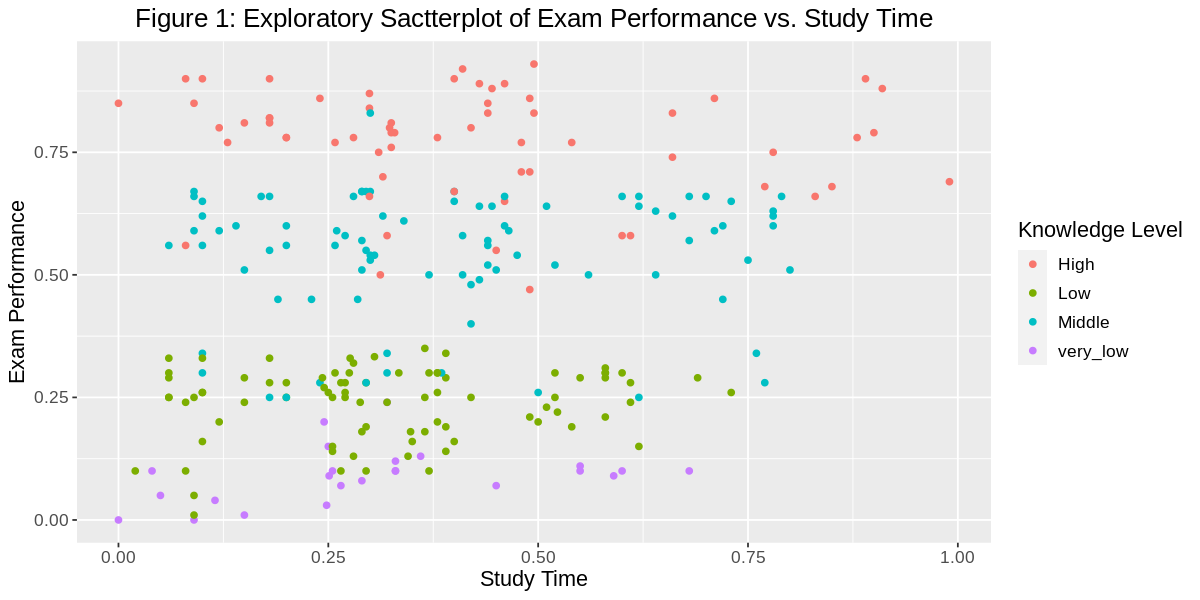

In [55]:
options(repr.plot.width = 10, repr.plot.height = 5)
exam_plot_study <- user_training %>%
            ggplot(aes(x = study_time_goal, y = exam_performance_goal)) +
            geom_point(aes(color = knowledge_level)) +
            labs(x = "Study Time", y = "Exam Performance", color = ("Knowledge Level")) +
            ggtitle("Figure 1: Exploratory Sactterplot of Exam Performance vs. Study Time") +
            theme(text = element_text(size = 13)) +
            theme(plot.title = element_text(hjust = 0.5))
exam_plot_study

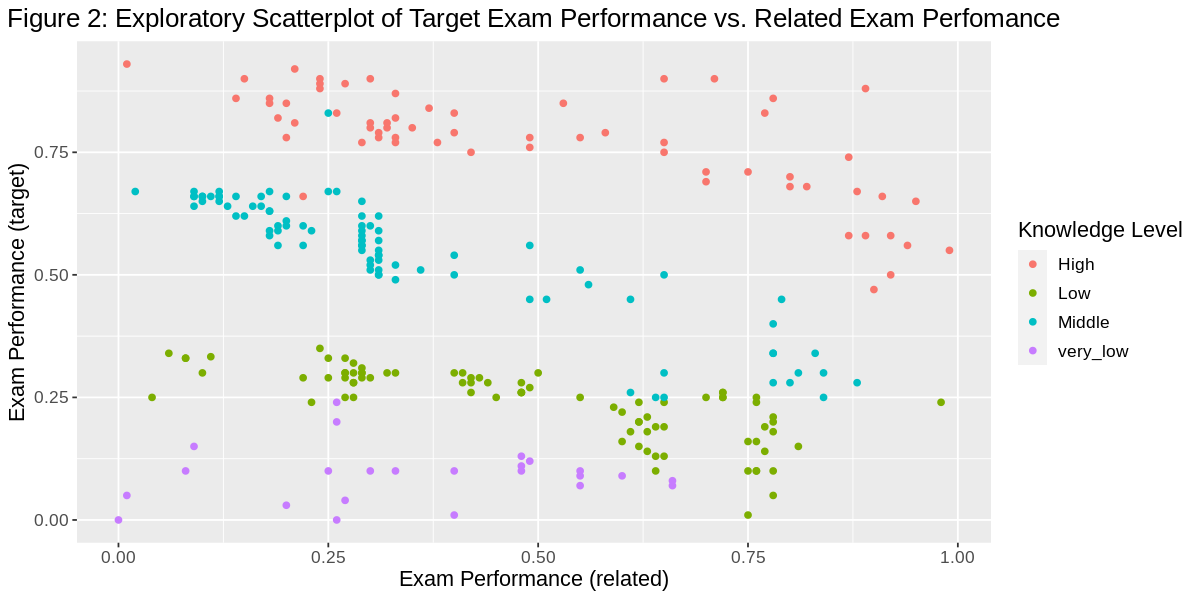

In [57]:
options(repr.plot.width = 10, repr.plot.height = 5)
exam_plot_related <- user_training %>%
            ggplot(aes(x = exam_performance_related, y = exam_performance_goal)) +
            geom_point(aes(color = knowledge_level)) +
            labs(x = "Exam Performance (related)", y = "Exam Performance (target)", color = ("Knowledge Level")) +
            ggtitle("Figure 2: Exploratory Scatterplot of Target Exam Performance vs. Related Exam Perfomance") +
            theme(text = element_text(size = 13)) +
            theme(plot.title = element_text(hjust = 0.5))
exam_plot_related

The next step in the analysis was figuring out how many neighbors should be used for the prediction. To determine this, a 5-fold cross validation was performed using the training data, testing up to 20 neighbors. It is important to note that the data appeared to have already been standardized, such that this step was not included in the recipe. Once the workflow was generated, the results were arranged and sliced to display the observation with the smallest rmse, and further plotted to confirm the output. As seen in figure 3 and table 4, the smallest rmse occurred when k = 4.

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,rmse,standard,0.06705298,5,0.005270866,Model04


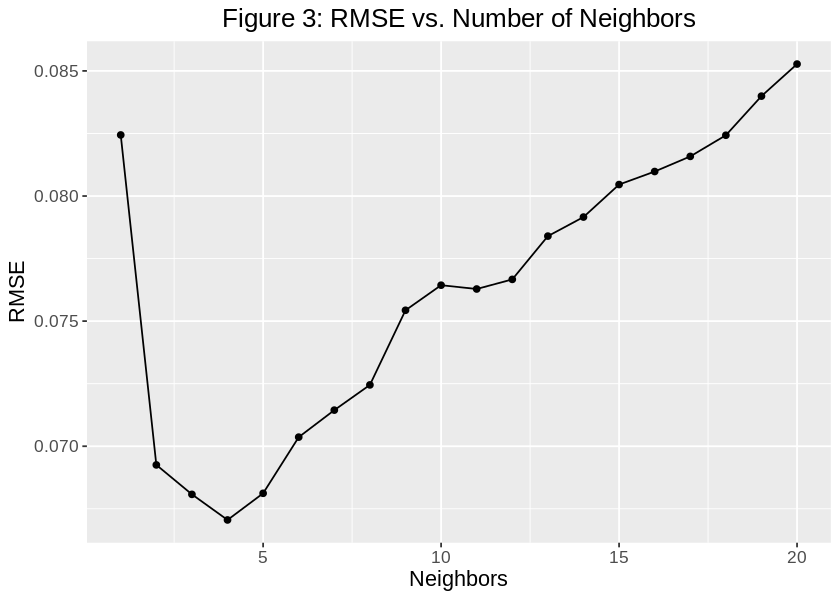

In [59]:
set.seed(2357)

# data already standardized
knowledge_recipe <- recipe(exam_performance_goal ~ study_time_goal + exam_performance_related + knowledge_level_numeric, 
                          data = user_training) 

training_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                set_engine("kknn") %>%
                set_mode("regression")

training_vfold <- vfold_cv(user_training, v = 5, strata = exam_performance_goal)
neighbors <- tibble(neighbors = 1:20)

training_fit <- workflow() %>%
                add_recipe(knowledge_recipe) %>%
                add_model(training_spec) %>%
                tune_grid(resamples = training_vfold, grid = neighbors) %>%
                collect_metrics() %>%
                filter(.metric == "rmse")

options(repr.plot.width = 7, repr.plot.height = 5)
training_plot <- training_fit %>%
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors", y = "RMSE") +
                ggtitle("Figure 3: RMSE vs. Number of Neighbors") +
                theme(text = element_text(size = 13)) +
                theme(plot.title = element_text(hjust = 0.5))
training_plot

training_results <- training_fit %>%
                    arrange(mean) %>%
                    slice(1)
training_results

With the number of neighbors determined, a new specification was created with k = 4, and a new workflow was generated. The fitted model was then used to predict the testing data, with the results summarized in table 5. The predictions were further used to calculate the rmspe for the model.

In [63]:
knowledge_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) %>%
                set_engine("kknn") %>%
                set_mode("regression")

knowledge_fit <- workflow() %>%
                add_recipe(knowledge_recipe) %>%
                add_model(knowledge_spec) %>%
                fit(user_training)

knowledge_prediction <- predict(knowledge_fit, user_testing) %>%
                    bind_cols(user_testing)
knowledge_prediction

knowledge_results <- knowledge_prediction %>%
                    metrics(truth = exam_performance_goal, estimate = .pred) %>%
                    filter(.metric == "rmse")
knowledge_results

.pred,study_time_goal,exam_performance_related,exam_performance_goal,knowledge_level,study_time_related,knowledge_level_numeric
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
0.0375,0.00,0.26,0.05,Very Low,0.50,1
0.2125,0.05,0.60,0.14,Low,0.55,2
0.6925,0.08,0.60,0.85,High,0.63,4
0.7350,0.20,0.67,0.85,High,0.68,4
0.7950,0.22,0.30,0.90,High,0.90,4
0.2675,0.14,0.50,0.30,Low,0.70,2
0.4275,0.16,0.50,0.50,Middle,0.80,3
0.1525,0.12,0.68,0.15,Low,0.75,2
0.6700,0.20,0.77,0.80,High,0.88,4


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.1055438


Lastly, the predictions were plotted alongside the testing data points. As there were multiple predictors, the visualization was once again split into 2 separate plots (one for study time and one for related exam performance), and further subdivided based on knowledge level. This was done for clarity, as the model often fluctuated and it was hard to compare to the data (there were no "trends" in the scatter plot as a whole to base the comparison on). As such, it was decided that comparing the predictions of each of the knowledge levels separately would provide more information on the performance of the model. The testing data points were plotted and connected with a line (colored based on the knowledge level), and the predictions were plotted using a solid blue line. 

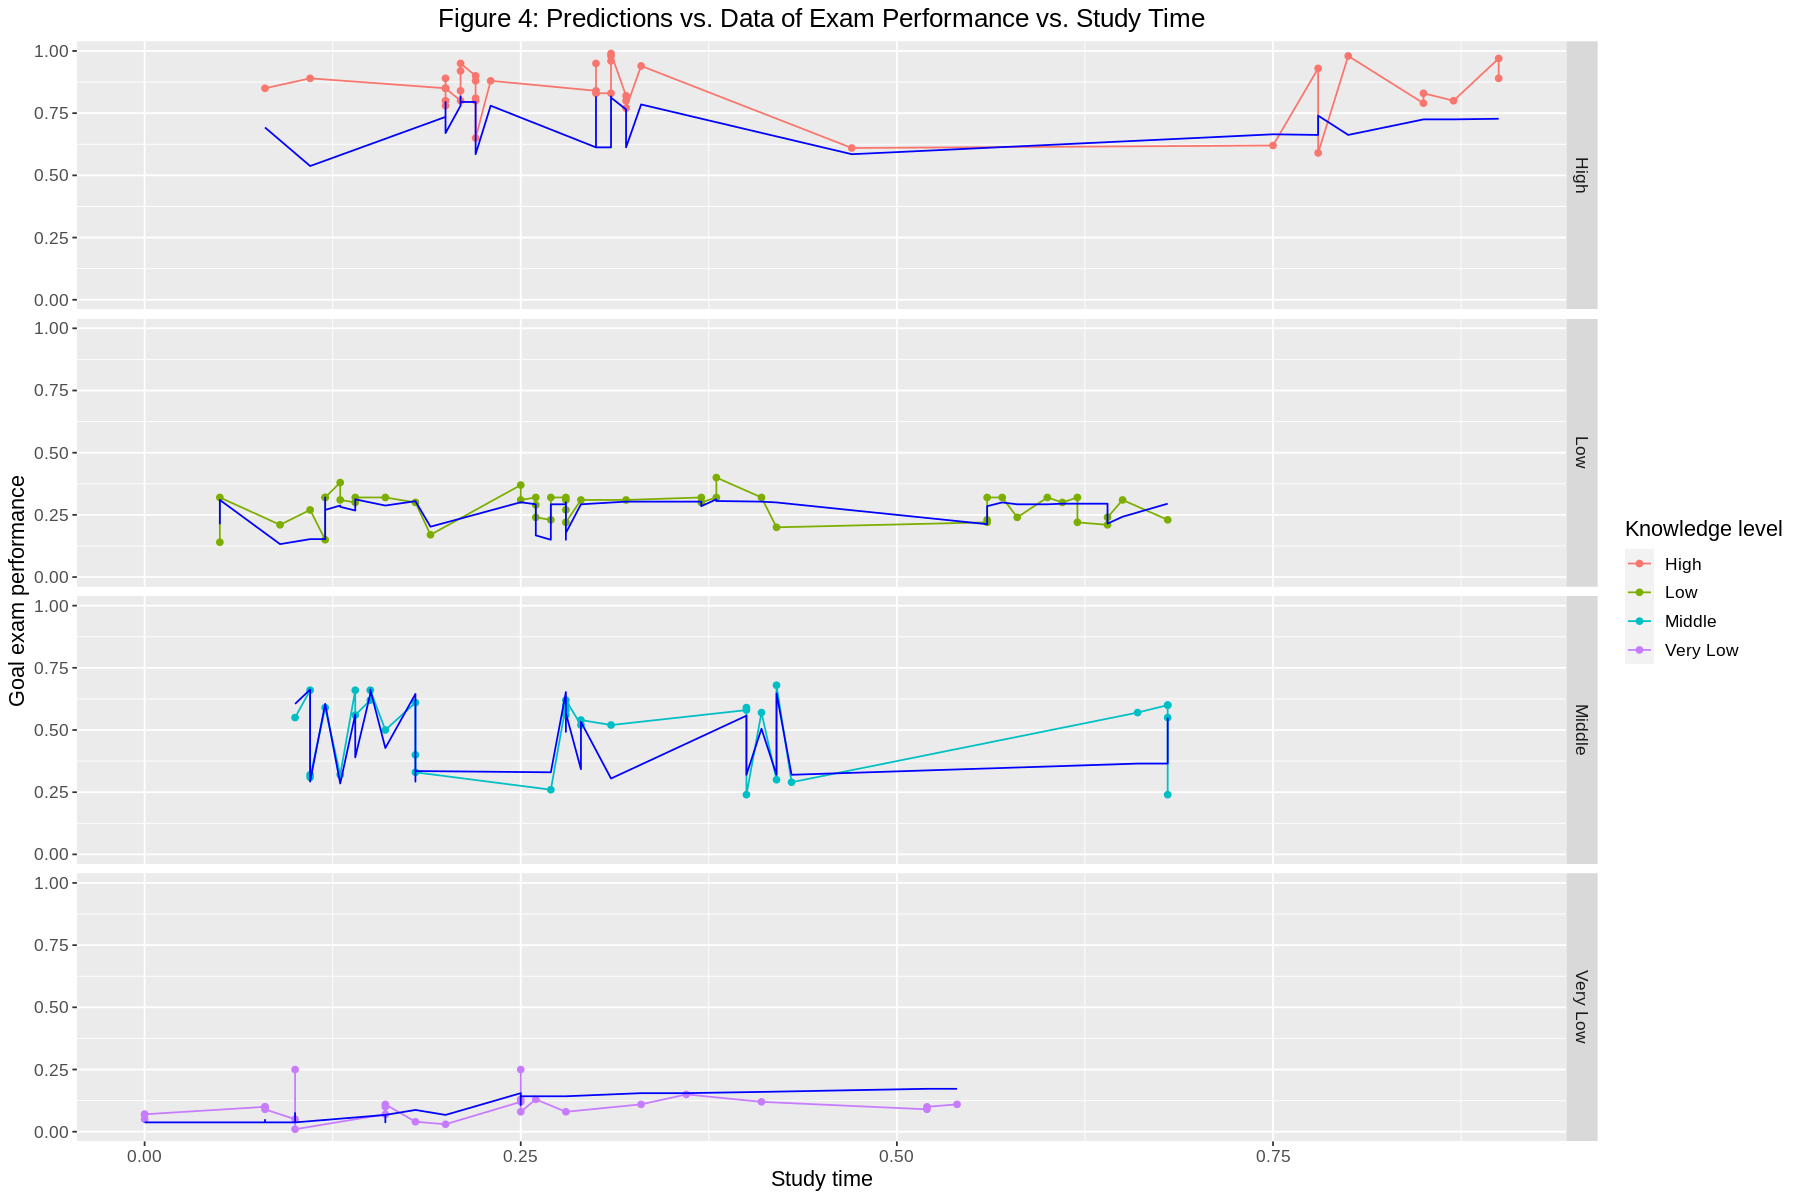

In [64]:
options(repr.plot.width = 15, repr.plot.height = 10)
study_plot <- user_testing %>%
            ggplot(aes(x = study_time_goal, y = exam_performance_goal)) +
            geom_point(aes(color = knowledge_level)) +
            geom_line(aes(color = knowledge_level)) +
            geom_line(data = knowledge_prediction,
                     mapping = aes(x = study_time_goal, y = .pred),
                     color = "blue") +
            facet_grid(rows = vars(knowledge_level)) +
            labs(x = "Study time", y = "Goal exam performance", color = "Knowledge level") +
            ggtitle("Figure 4: Predictions vs. Data of Exam Performance vs. Study Time") +
            theme(text = element_text(size = 13)) +
            theme(plot.title = element_text(hjust = 0.5))
study_plot

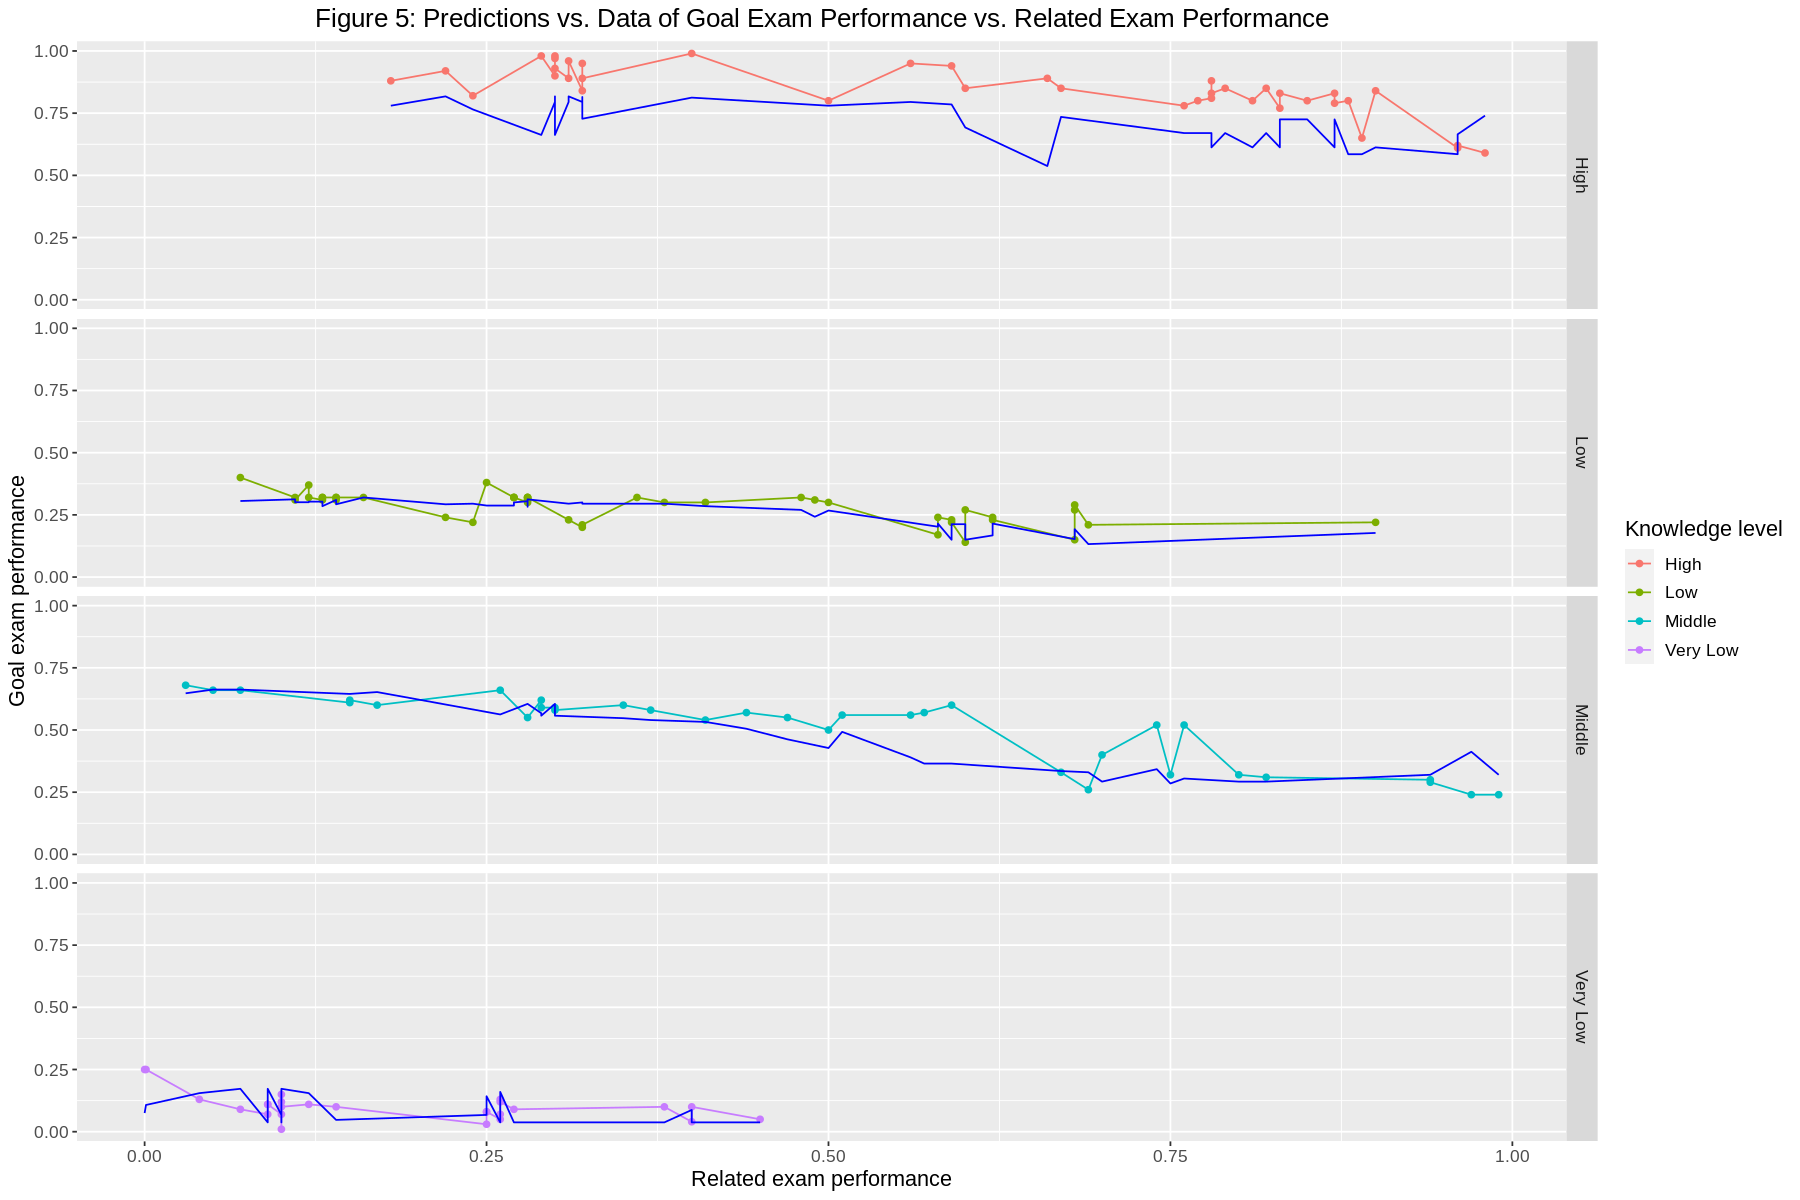

In [65]:
options(repr.plot.width = 15, repr.plot.height = 10)
exam_plot <- user_testing %>%
            ggplot(aes(x = exam_performance_related, y = exam_performance_goal)) +
            geom_point(aes(color = knowledge_level)) +
            geom_line(aes(color = knowledge_level)) +
            geom_line(data = knowledge_prediction,
                     mapping = aes(x = exam_performance_related, y = .pred),
                     color = "blue") +
            facet_grid(rows = vars(knowledge_level)) +
            labs(x = "Related exam performance", y = "Goal exam performance", color = "Knowledge level") +
            ggtitle("Figure 5: Predictions vs. Data of Goal Exam Performance vs. Related Exam Performance") +
            theme(text = element_text(size = 13)) +
            theme(plot.title = element_text(hjust = 0.5))
exam_plot